In [1]:
import pandas as pd
import numpy as np
from scipy import stats
from matplotlib import pyplot as plt
from scipy.special import expit
import seaborn as sns
import graphviz as gr

from toolz import curry

import statsmodels.formula.api as smf

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelBinarizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_auc_score, r2_score

import lightgbm as lgbm


# Problem Setup

$$
Risk(i) = \dfrac{1}{1+e^{-(a+bi)}}
$$

$$
Loss(amt, i) = amt * Risk(i)
$$

$$
Rev(amt, i) = amt * \big((i+1)^t - 1 \big)*\big(1-Risk(i)\big)
$$

$$
i^*= \underset{i}{argmax} \bigg\{  amt * \big((i+1)^t - 1 \big)*\big(1-Risk(i)\big)  - amt * Risk(i) \bigg\}
$$

In [2]:
def risk(i, a=-5, b=50):
    return expit(a + b*i)

def loss(amt, i, a=-5, b=50):
    return amt * risk(i, a=a, b=b)

def rev(amt, i, t=12, a=-5, b=50):
    return amt * ((i+1)**t)*(1-risk(i, a=a, b=b))

def profit(amt, i, t=5, a=-5, b=50):
    return rev(amt, i, t=t, a=a, b=b) - loss(amt, i, a=a, b=b)


def profit_given_risk(i, risk, amt=1000, t=5):
    return amt * ((i+1)**t)*(1-risk) - amt * risk

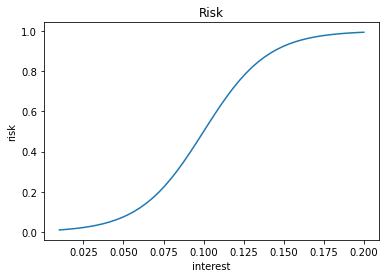

In [3]:
i = np.linspace(0.01, 0.2)
plt.plot(i, risk(i))
plt.ylabel("risk")
plt.xlabel("interest")
plt.title("Risk");

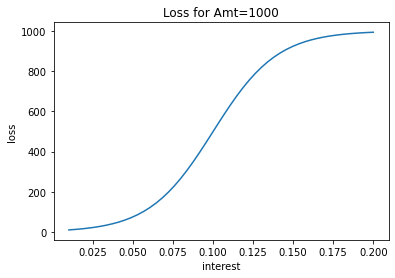

In [4]:
i = np.linspace(0.01, 0.2)
plt.plot(i, loss(1000, i))
plt.title("Loss for Amt=1000")
plt.ylabel("loss")
plt.xlabel("interest");

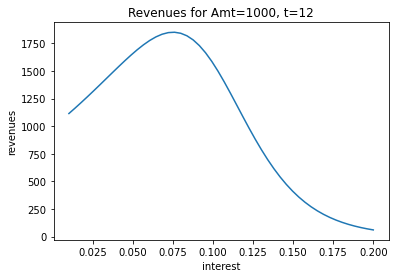

In [5]:
i = np.linspace(0.01, 0.2)
plt.plot(i, rev(1000, i, t=12))
plt.title("Revenues for Amt=1000, t=12")
plt.ylabel("revenues")
plt.xlabel("interest");

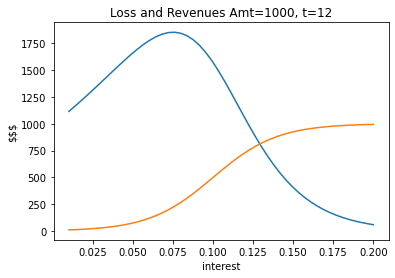

In [6]:
i = np.linspace(0.01, 0.2)
plt.plot(i, rev(1000, i, t=12))
plt.plot(i, loss(1000, i))
plt.title("Loss and Revenues Amt=1000, t=12")
plt.ylabel("$$$")
plt.xlabel("interest");

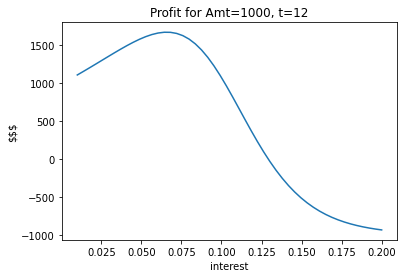

In [7]:
i = np.linspace(0.01, 0.2)
plt.plot(i, profit(1000, i, t=12))
plt.title("Profit for Amt=1000, t=12")
plt.ylabel("$$$")
plt.xlabel("interest");

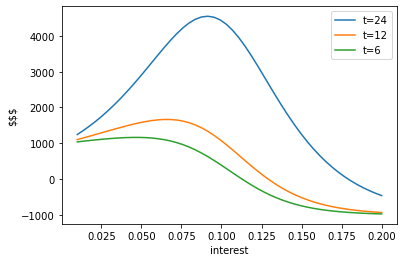

In [8]:
i = np.linspace(0.01, 0.2)
plt.plot(i, profit(1000, i, t=24), label="t=24")
plt.plot(i, profit(1000, i, t=12), label="t=12")
plt.plot(i, profit(1000, i, t=6), label="t=6")
plt.legend()
plt.ylabel("$$$")
plt.xlabel("interest");

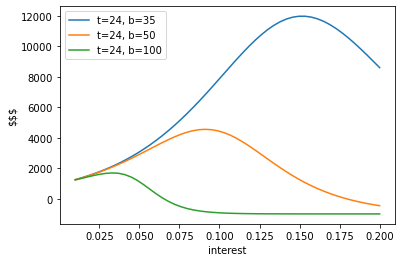

In [9]:
i = np.linspace(0.01, 0.2)
plt.plot(i, profit(1000, i, t=24, b=35),  label="t=24, b=35")
plt.plot(i, profit(1000, i, t=24, b=50),  label="t=24, b=50")
plt.plot(i, profit(1000, i, t=24, b=100), label="t=24, b=100")

plt.legend()
plt.ylabel("$$$")
plt.xlabel("interest");

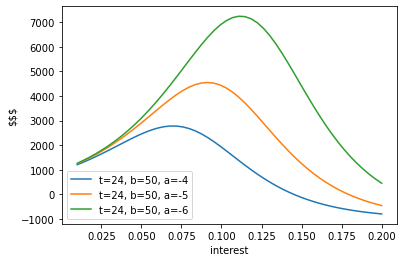

In [10]:
i = np.linspace(0.01, 0.2)
plt.plot(i, profit(1000, i, t=24, b=50, a=-4),  label="t=24, b=50, a=-4")
plt.plot(i, profit(1000, i, t=24, b=50, a=-5),  label="t=24, b=50, a=-5")
plt.plot(i, profit(1000, i, t=24, b=50, a=-6),  label="t=24, b=50, a=-6")

plt.legend()
plt.ylabel("$$$")
plt.xlabel("interest");

### Gathering Data

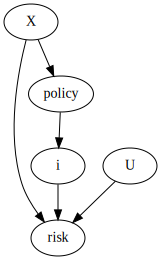

In [11]:
g = gr.Digraph()
g.edge("i", "risk")
g.edge("X", "risk")
g.edge("X", "policy")
g.edge("policy", "i")
g.edge("U", "risk")
g

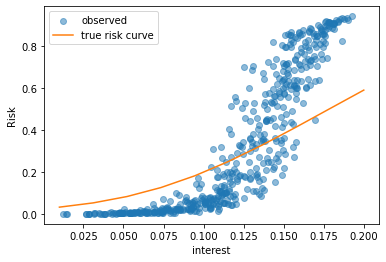

In [12]:
n = 500
a = np.random.uniform(-2, -7, size=n)

# generate biased data
i = np.random.beta((a+8)*4, -a*2)*0.2
r = risk(i, a=a, b=25)

# generate counterfactuals
exp_i_df = (pd.DataFrame(dict(a=a, key=1))
            .merge(pd.DataFrame(dict(key=1, i = np.linspace(0.01, 0.2, 10))))
            .assign(risk = lambda d: risk(i=d["i"], a=d["a"], b=25)))

plt.scatter(i, r, alpha=0.5, label="observed")
exp_i_df.groupby("i")["risk"].mean().plot(label="true risk curve", color="C1")
plt.legend()
plt.ylabel("Risk")
plt.xlabel("interest");

Optimization terminated successfully.
         Current function value: 0.367877
         Iterations 7


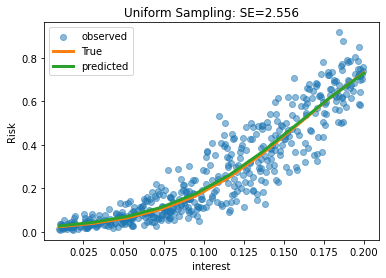

In [13]:
n = 500

np.random.seed(123)
i = np.random.uniform(0.01, 0.2, size=n)

a = -4
b = 25

r = expit(np.random.normal(a + b*i, 0.5))

model = smf.logit("r ~ i", data=pd.DataFrame(dict(r=r, i=i))).fit()


plt.scatter(i, r, alpha=0.5, label="observed")

x = np.linspace(0.01, 0.2, 10)
plt.plot(x, risk(x, a=a, b=b), color="C1", lw=3, label="True")
plt.plot(x, model.predict(pd.DataFrame(dict(i=x))), color="C2", lw=3, label="predicted")

plt.legend()
plt.title("Uniform Sampling: SE=" + str(round(model.bse["i"], 3)))
plt.ylabel("Risk")
plt.xlabel("interest");

Optimization terminated successfully.
         Current function value: 0.282923
         Iterations 8


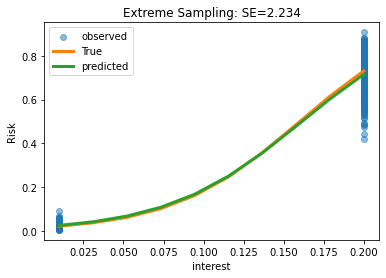

In [14]:
np.random.seed(123)

i = np.random.choice(np.linspace(0.01, 0.2, 2), size=n)
r = expit(np.random.normal(a + b*i, 0.5))

model = smf.logit("r ~ i", data=pd.DataFrame(dict(r=r, i=i))).fit()

plt.scatter(i, r, alpha=0.5, label="observed")

x = np.linspace(0.01, 0.2, 10)
plt.plot(x, risk(x, a=a, b=b), color="C1", lw=3, label="True")
plt.plot(x, model.predict(pd.DataFrame(dict(i=x))), color="C2", lw=3, label="predicted")

plt.legend()
plt.title("Extreme Sampling: SE=" + str(round(model.bse["i"], 3)))
plt.ylabel("Risk")
plt.xlabel("interest");

Optimization terminated successfully.
         Current function value: 0.312553
         Iterations 7


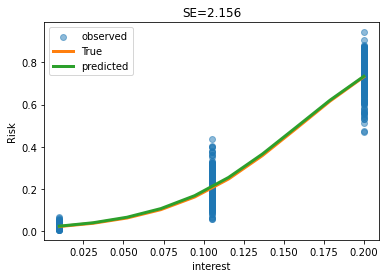

In [15]:
np.random.seed(123)
i = np.random.choice(np.linspace(0.01, 0.2, 3), size=n)

r = expit(np.random.normal(a + b*i, 0.5))

model = smf.logit("r ~ i", data=pd.DataFrame(dict(r=r, i=i))).fit()

plt.scatter(i, r, alpha=0.5, label="observed")

x = np.linspace(0.01, 0.2, 10)
plt.plot(x, risk(x, a=a, b=b), color="C1", lw=3, label="True")

plt.plot(x, model.predict(pd.DataFrame(dict(i=x))), color="C2", lw=3, label="predicted")

plt.legend()
plt.title("SE=" + str(round(model.bse["i"], 3)))
plt.ylabel("Risk")
plt.xlabel("interest");

Optimization terminated successfully.
         Current function value: 0.350894
         Iterations 7


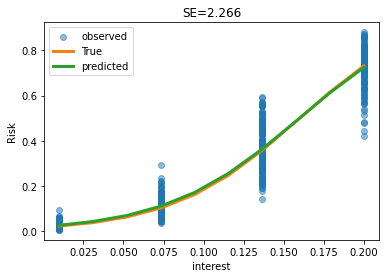

In [16]:
np.random.seed(123)
i = np.random.choice(np.linspace(0.01, 0.2, 4), size=n)

r = expit(np.random.normal(a + b*i, 0.5))

model = smf.logit("r ~ i", data=pd.DataFrame(dict(r=r, i=i))).fit()

plt.scatter(i, r, alpha=0.5, label="observed")

x = np.linspace(0.01, 0.2, 10)
plt.plot(x, risk(x, a=a, b=b), color="C1", lw=3, label="True")

plt.plot(x, model.predict(pd.DataFrame(dict(i=x))), color="C2", lw=3, label="predicted")

plt.legend()
plt.title("SE=" + str(round(model.bse["i"], 3)))
plt.ylabel("Risk")
plt.xlabel("interest");

In [17]:
result = []


for p in np.linspace(0.01, 0.99, 100):
    
    np.random.seed(123)
    i = np.random.choice([0.01, 0.2], p=[p, 1-p], size=n)

    r = expit(np.random.normal(a + b*i, 0.5))

    model = smf.logit("r ~ i", data=pd.DataFrame(dict(r=r, i=i))).fit(disp=0)

    result.append({"se": model.bse["i"], "p":p})

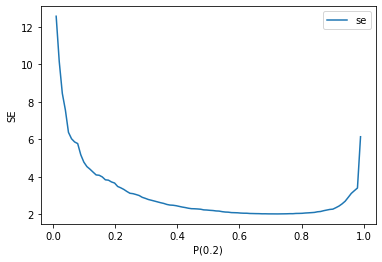

In [18]:
pd.DataFrame(result).set_index("p").plot()
plt.xlabel("P(0.2)");
plt.ylabel("SE");

Optimization terminated successfully.
         Current function value: 0.151473
         Iterations 8


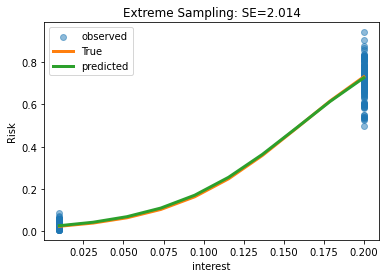

In [19]:
np.random.seed(123)
p = 0.722727
i = np.random.choice([0.01, 0.2], p=[p, 1-p], size=n)

r = expit(np.random.normal(a + b*i, 0.5))

model = smf.logit("r ~ i", data=pd.DataFrame(dict(r=r, i=i))).fit()

plt.scatter(i, r, alpha=0.5, label="observed")

x = np.linspace(0.01, 0.2, 10)
plt.plot(x, risk(x, a=a, b=b), color="C1", lw=3, label="True")

plt.plot(x, model.predict(pd.DataFrame(dict(i=x))), color="C2", lw=3, label="predicted")

plt.legend()
plt.title("Extreme Sampling: SE=" + str(round(model.bse["i"], 3)))
plt.ylabel("Risk")
plt.xlabel("interest");

Optimization terminated successfully.
         Current function value: 0.353396
         Iterations 6


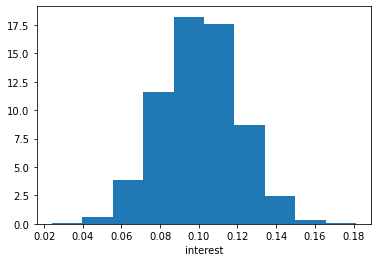

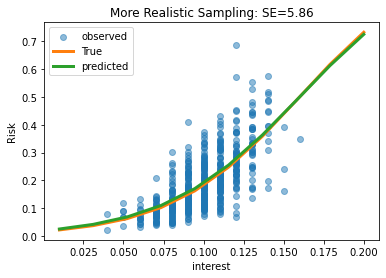

In [20]:
n = 500

np.random.seed(123)
i = np.random.normal(0.1, 0.02, size=n).clip(0, 1).round(2)
a = -4
b = 25

r = expit(np.random.normal(a + b*i, 0.5))

model = smf.logit("r ~ i", data=pd.DataFrame(dict(r=r, i=i))).fit()

plt.hist(np.random.normal(0.1, 0.02, size=10000), density=True)
plt.xlabel("interest");
plt.show()

plt.scatter(i, r, alpha=0.5, label="observed")

x = np.linspace(0.01, 0.2, 10)
plt.plot(x, risk(x, a=a, b=b), color="C1", lw=3, label="True")

plt.plot(x, model.predict(pd.DataFrame(dict(i=x))), color="C2", lw=3, label="predicted")

plt.legend()
plt.title("More Realistic Sampling: SE=" + str(round(model.bse["i"], 3)))
plt.ylabel("Risk")
plt.xlabel("interest");

## Batch Estimation

In [21]:
n = 10000

# generate data from random i
np.random.seed(1)

i_rnd = np.random.normal(0.1, 0.02, size=n-100).clip(0, 1).round(2)
i_pos = np.random.uniform(0.01, 0.21, size=100).round(2)
i = np.concatenate([i_pos, i_rnd])

feature = 1/np.random.uniform(2, 6, size=n)
a = -1/feature
b = 25
r = expit(np.random.normal(a + b*i, 0.5))

rnd_df = pd.DataFrame(dict(i=i, x=feature, r=r, b=b, a=a, profit = profit_given_risk(i, r)))

# estimate the propensity score
rnd_df = rnd_df.set_index("i").join((rnd_df.groupby("i").size()/rnd_df.shape[0]).rename("ps")).reset_index()

In [22]:
n = 50000

# generate data from biased i 
np.random.seed(2)

feature = 1/np.random.uniform(2, 6, size=n)
a = -1/feature
b = 25
i = (np.random.beta((a+8)*4, -a*2)*0.2).round(2)
r = expit(np.random.normal(a + b*i, 0.5))

policy_df = pd.DataFrame(dict(i=i, x=feature, r=r, b=b, a=a))

### Non Causal Model

In [23]:
np.random.seed(321)
model = lgbm.LGBMRegressor()
model.fit(policy_df[["i", "x"]], policy_df["r"])

pred_exp = rnd_df.assign(prediction = lambda d: model.predict(d[["i", "x"]]))

r2_obs = r2_score(pred_exp["r"], pred_exp["prediction"])

r2_obs

0.8227169771785412

### Causal Model

In [24]:
ps_model = OneVsRestClassifier(LogisticRegression(multi_class="multinomial"))
lb = LabelBinarizer() 

y = lb.fit_transform(policy_df["i"].astype("str").values)

ps_model.fit(policy_df[["x"]], y)

OneVsRestClassifier(estimator=LogisticRegression(multi_class='multinomial'))

In [25]:
conditional = ps_model.predict_proba(policy_df[["x"]])

ps = 1/np.select([policy_df["i"] == float(i) for i in lb.classes_],
                 [conditional[:, i] for i in range(conditional.shape[1])])



In [26]:
model_causal = lgbm.LGBMRegressor()

model_causal.fit(policy_df[["i", "x"]], policy_df["r"], sample_weight=ps)

pred_exp_causal = rnd_df.assign(prediction = lambda d: model_causal.predict(d[["i", "x"]]))

r2_causal = r2_score(pred_exp_causal["r"], pred_exp_causal["prediction"])
r2_causal

0.8167162702141274

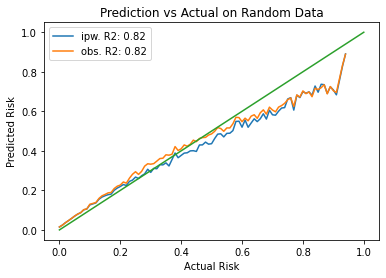

In [27]:
pred_exp_causal.round({"r": 2}).groupby("r")["prediction"].mean().plot(label=f"ipw. R2: {np.round(r2_causal,2)}")
pred_exp.round({"r": 2}).groupby("r")["prediction"].mean().plot(label=f"obs. R2: {np.round(r2_obs,2)}")
plt.plot([0, 1], [0, 1])
plt.legend()
plt.title("Prediction vs Actual on Random Data")
plt.xlabel("Actual Risk");
plt.ylabel("Predicted Risk");

## Validate on New Data

In [28]:
np.random.seed(3)

n=20000

feature = 1/np.random.uniform(2, 6, size=n)
a = -1/feature
b = 25

exploded = (pd.DataFrame(dict(x=feature, b=b, a=a, key=1))
            .reset_index()
            .merge(pd.DataFrame(dict(i=np.arange(0.01, 0.21, 0.01).round(2), key=1)))
            .assign(r = lambda d: expit(d["a"] + d["b"]*d["i"]))
            .assign(profit = lambda d: profit_given_risk(d["i"], d["r"]))
            .drop(columns=["key"])
           )

In [29]:
decision_df = (exploded
               .assign(pred = lambda d: profit_given_risk(i=d["i"], risk=model.predict(d[["i", "x"]])),
                       pred_risk = lambda d: model.predict(d[["i", "x"]]))
               .assign(prediction_rank = lambda d: d.groupby("index")["pred"].transform("rank", method="first", ascending=False))
               .query("prediction_rank==1")
               .drop(columns=["index", "prediction_rank"]))


In [30]:
r2_score(decision_df["profit"], decision_df["pred"])

0.8657217932366762

In [31]:
r2_score(decision_df["r"], decision_df["pred_risk"])

0.9018107783746077

In [32]:
decision_causal_df = (exploded
                      .assign(pred = lambda d: profit_given_risk(i=d["i"], risk=model_causal.predict(d[["i", "x"]])),
                              pred_risk = lambda d: model_causal.predict(d[["i", "x"]]))
                      .assign(prediction_rank = lambda d: d.groupby("index")["pred"].transform("rank", method="first", ascending=False))
                      .query("prediction_rank==1")
                      .drop(columns=["index", "prediction_rank"]))



In [33]:
r2_score(decision_causal_df["profit"], decision_causal_df["pred"])

0.8494425170369657

In [34]:
r2_score(decision_causal_df["r"], decision_causal_df["pred_risk"])

0.7745243001109174

In [35]:
ci_profit_causal = decision_causal_df["profit"].mean()+np.array([-1, 1])*1.96*decision_causal_df["profit"].sem()
ci_profit_causal

array([1066.39709231, 1078.12666642])

In [36]:
ci_profit_obs = decision_df["profit"].mean()+np.array([-1, 1])*1.96*decision_df["profit"].sem()
ci_profit_obs

array([1010.12408295, 1021.17413593])

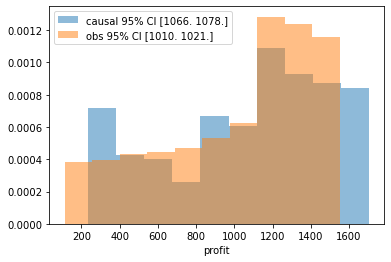

In [37]:
plt.hist(decision_causal_df["profit"], density=True, alpha=0.5, label=f"causal 95% CI {ci_profit_causal.round()}");
plt.hist(decision_df["profit"], density=True, alpha=0.5, label=f"obs 95% CI {ci_profit_obs.round()}")
plt.xlabel("profit")
plt.legend();


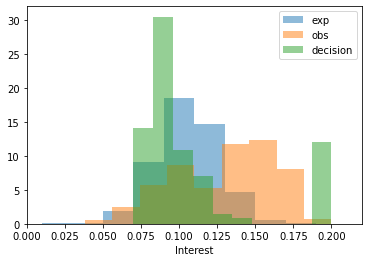

In [38]:
plt.hist(pred_exp["i"], density=True, alpha=0.5, label="exp");
plt.hist(policy_df["i"], density=True, alpha=0.5, label="obs");
plt.hist(decision_df["i"], density=True, alpha=0.5, label="decision");

plt.legend()
plt.xlabel("Interest");

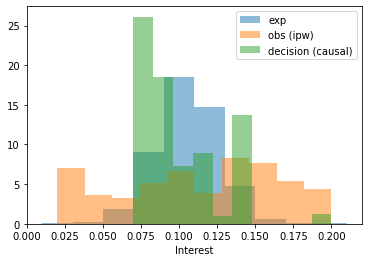

In [39]:
plt.hist(pred_exp["i"], density=True, alpha=0.5, label="exp");
plt.hist(policy_df["i"], density=True, alpha=0.5, label="obs (ipw)", weights=ps);
plt.hist(decision_causal_df["i"], density=True, alpha=0.5, label="decision (causal)");

plt.legend()
plt.xlabel("Interest");

### Causal Metric

<AxesSubplot:xlabel='i'>

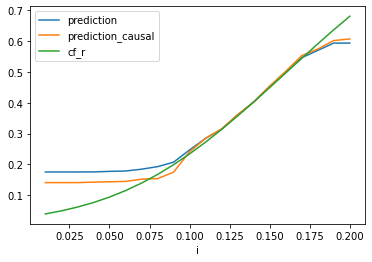

In [40]:
pred_exp = (rnd_df
            .reset_index()
            .rename(columns={"i": "io"})
            .assign(key=1)
            .merge(pd.DataFrame(dict(key=1, i = np.arange(0.01, 0.21, 0.01).round(2))))
            .assign(cf_r = lambda d: expit(d["a"] + d["b"]*d["i"]))
            .assign(prediction = lambda d: model.predict(d[["i", "x"]]))
            .assign(prediction_causal = lambda d: model_causal.predict(d[["i", "x"]]))
)

pred_exp.groupby("i")[["prediction", "prediction_causal", "cf_r"]].mean().plot()

In [41]:
obs_r2 = r2_score(pred_exp["cf_r"], pred_exp["prediction"])
obs_r2

0.8876369074481718

In [42]:
causal_r2 = r2_score(pred_exp["cf_r"], pred_exp["prediction_causal"])
causal_r2

0.9412982530253565

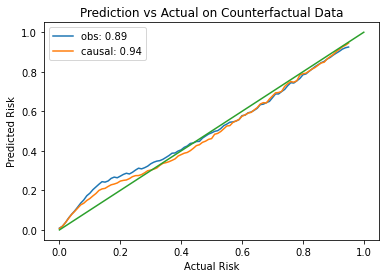

In [43]:
plt_df = pred_exp.round({"cf_r": 2}).groupby("cf_r")[["prediction", "prediction_causal"]].mean()

plt.plot(plt_df["prediction"], label=f"obs: {round(obs_r2, 2)}")
plt.plot(plt_df["prediction_causal"], label=f"causal: {round(causal_r2, 2)}")

plt.plot([0, 1], [0, 1])

plt.legend()
plt.title("Prediction vs Actual on Counterfactual Data")
plt.xlabel("Actual Risk");
plt.ylabel("Predicted Risk");

In [44]:
pred_rnd = (rnd_df
            .assign(prediction = lambda d: model.predict(d[["i", "x"]]))
            .assign(prediction_causal = lambda d: model_causal.predict(d[["i", "x"]]))
)

Text(0.5, 0, 'interest')

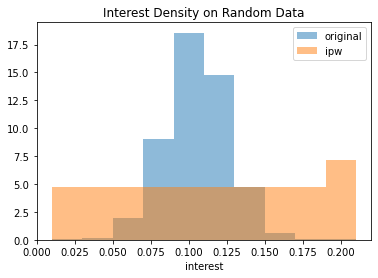

In [45]:
plt.hist(pred_rnd["i"], alpha=0.5, density=True, label="original")
plt.hist(pred_rnd["i"], alpha=0.5, density=True, weights=1/pred_rnd["ps"], label="ipw")
plt.legend()
plt.title("Interest Density on Random Data")
plt.xlabel("interest")

In [46]:
print(r2_score(pred_rnd["r"], pred_rnd["prediction_causal"], sample_weight=1/pred_rnd["ps"]))
print(r2_score(pred_rnd["r"], pred_rnd["prediction"], sample_weight=1/pred_rnd["ps"]))

0.8675069675847378
0.8309960336422443


In [47]:
print(r2_score(pred_rnd["r"], pred_rnd["prediction_causal"]))
print(r2_score(pred_rnd["r"], pred_rnd["prediction"]))

0.8167162702141274
0.8227169771785412


In [48]:
obs_r2 = r2_score(pred_rnd["r"], pred_rnd["prediction"], sample_weight=1/pred_rnd["ps"])
causal_r2 = r2_score(pred_rnd["r"], pred_rnd["prediction_causal"], sample_weight=1/pred_rnd["ps"])

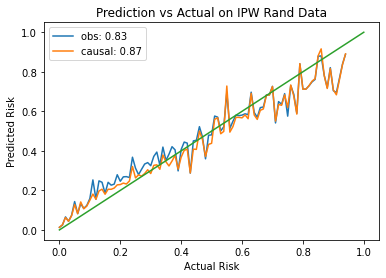

In [49]:
plt_df_ops = (pred_rnd
              .round({"r": 2})
              .groupby("r")
              .apply(lambda d: np.average(d["prediction"], weights=1/d["ps"])))


plt_df_causal = (pred_rnd
                 .round({"r": 2})
                 .groupby("r")
                 .apply(lambda d: np.average(d["prediction_causal"], weights=1/d["ps"])))


plt.plot(plt_df_ops, label=f"obs: {round(obs_r2, 2)}")
plt.plot(plt_df_causal, label=f"causal: {round(causal_r2, 2)}")

plt.plot([0, 1], [0, 1])

plt.legend()
plt.title("Prediction vs Actual on IPW Rand Data")
plt.xlabel("Actual Risk");
plt.ylabel("Predicted Risk");

## Offline Policy Evaluation

$$
\dfrac{Q(T_i|X_i)}{P(T_i|X_i)}
$$

Text(0.5, 0, 'Interest')

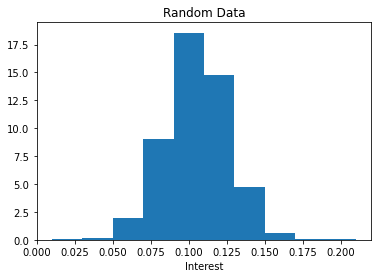

In [50]:
plt.hist(rnd_df["i"], density=True)
plt.title("Random Data")
plt.xlabel("Interest")

Text(0.5, 0, 'Interest')

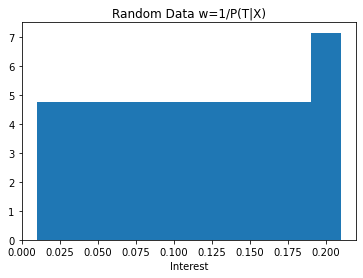

In [51]:
plt.hist(rnd_df["i"], density=True, weights=1/rnd_df["ps"])
plt.title("Random Data w=1/P(T|X)")
plt.xlabel("Interest")

Text(0.5, 0, 'Interest')

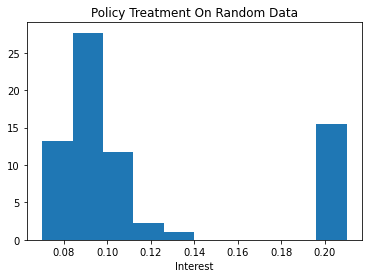

In [52]:
plt.hist((rnd_df
          .reset_index()
          .assign(key=1)
          .merge(pd.DataFrame(dict(key=1, i_policy = sorted(rnd_df["i"].unique()))))
          .assign(risk_pred = lambda d: model.predict(d[["i_policy", "x"]]))
          .assign(profit_pred = lambda d: profit_given_risk(d["i_policy"], d["risk_pred"]))
          .assign(prediction_rank = lambda d: d.groupby("index")["profit_pred"].transform("rank", method="first", ascending=False))
          .query("prediction_rank==1")
          ["i_policy"]),
         density=True)

plt.title("Policy Treatment On Random Data")
plt.xlabel("Interest")

In [53]:
def with_policy(df, model):
    
    all_prices = sorted(df["i"].unique())
    
    return (
        df
        .reset_index()
        .assign(key=1)
        .merge(pd.DataFrame(dict(key=1, i_policy = all_prices)))
        .assign(risk_pred = lambda d: model.predict(d[["i_policy", "x"]]))
        .assign(profit_pred = lambda d: profit_given_risk(d["i_policy"], d["risk_pred"]))
        .assign(prediction_rank = lambda d: d.groupby("index")["profit_pred"].transform("rank", method="first", ascending=False))
        .assign(qs = lambda d: (d["prediction_rank"] == 1)*1)
        .query("i==i_policy")
        .drop(columns=["prediction_rank", "key", "index"])
        
    )

rnd_policy_pred = with_policy(rnd_df, model)
rnd_policy_causal_pred = with_policy(rnd_df, model_causal)

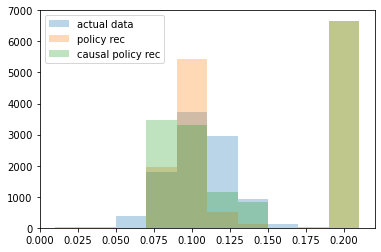

In [54]:
plt.hist(rnd_df["i"], label="actual data", alpha=0.3)
plt.hist(rnd_policy_pred["i"], weights=rnd_policy_pred["qs"]/rnd_policy_pred["ps"], label="policy rec", alpha=0.3)
plt.hist(rnd_policy_causal_pred["i"], weights=rnd_policy_causal_pred["qs"]/rnd_policy_causal_pred["ps"], label="causal policy rec", alpha=0.3)

plt.legend()

In [55]:
np.average(rnd_policy_pred["profit"], weights=rnd_policy_pred["qs"]/rnd_policy_pred["ps"])

1007.2884346000333

In [56]:
np.average(rnd_policy_causal_pred["profit"], weights=rnd_policy_causal_pred["qs"]/rnd_policy_causal_pred["ps"])

1034.3315212406117

In [57]:
def w_avg(df):
    return np.average(df["profit"], weights=df["qs"]/df["ps"])

bs_sample_causal = [w_avg(rnd_policy_causal_pred.sample(frac=1, replace=True)) for _ in range(500)]

In [58]:
np.quantile(bs_sample_causal, [0.025, 0.975])

array([ 954.2258764 , 1097.21969004])

In [59]:
def w_avg(df):
    return np.average(df["profit"], weights=df["qs"]/df["ps"])

bs_sample = [w_avg(rnd_policy_pred.sample(frac=1, replace=True)) for _ in range(500)]

In [60]:
np.quantile(bs_sample, [0.025, 0.975])

array([ 898.75008347, 1082.44322125])

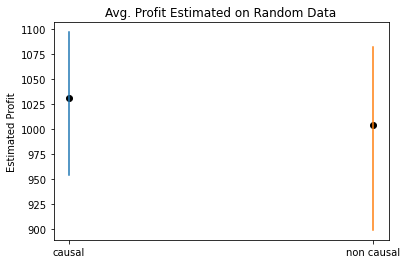

In [61]:
plt.title("Avg. Profit Estimated on Random Data")
plt.plot(["causal", "causal"], np.quantile(bs_sample_causal, [0.025, 0.975]), label="causal")
plt.plot(["non causal", "non causal"], np.quantile(bs_sample, [0.025, 0.975]), label="non causal")
plt.scatter(["causal", "non causal"], [np.quantile(bs_sample_causal, 0.5), np.quantile(bs_sample, 0.5)], color="black")
plt.ylabel("Estimated Profit");

## Towards Causal RL

In [62]:
def with_policy_prices(df, model):
    
    all_prices = np.arange(0.01, 0.21, 0.01).round(2)
    
    return (
        df
        .reset_index()
        .assign(key=1)
        .merge(pd.DataFrame(dict(key=1, i = all_prices)))
        .assign(risk_pred = lambda d: model.predict(d[["i", "x"]]))
        .assign(profit_pred = lambda d: profit_given_risk(d["i"], d["risk_pred"]))
        .assign(prediction_rank = lambda d: d.groupby("index")["profit_pred"].transform("rank", method="first", ascending=False))
        .query("prediction_rank==1")
        .drop(columns=["prediction_rank", "key", "risk_pred", "profit_pred", "index"])
        
    )

In [63]:
n_rnd = 10000
n_policy = 20000
n = n_rnd+n_policy

np.random.seed(1)

feature = 1/np.random.uniform(2, 6, size=n)
a = -1/feature
b = 25


i_rnd = np.random.normal(0.1, 0.02, size=n-100).clip(0, 1).round(2)
i_pos = np.random.uniform(0.01, 0.21, size=100).round(2)
i = np.concatenate([i_pos, i_rnd]).round(2)

ps = (pd.DataFrame(dict(i=i)).groupby("i").size()/n).rename("test_ps")

is_exp = np.random.binomial(1, n_rnd/n, n)


df_policy = (with_policy_prices(pd.DataFrame(dict(x = feature, a=a, b=b)), model_causal)
             .assign(is_exp = is_exp,
                     p_exp = n_rnd/n,
                     i_policy = lambda d: d["i"],
                     i_exp = i,
                     i = lambda d: d["i"].where(is_exp==0, i)).round(2)
             .merge(ps.reset_index(), how="left")
             .fillna({"ps": 0})
             .assign(ps = lambda d: np.where(d["is_exp"]==1, d["test_ps"]*(n_rnd/n), 1*(1-(n_rnd/n))),
                     r = lambda d: expit(np.random.normal(d["a"] + d["b"]*d["i"])))
             .assign(profit = lambda d: profit_given_risk(d["i"], d["r"]))
             
            )

df_policy.head().drop(columns=["a", "b"])

,x,i,is_exp,p_exp,i_policy,i_exp,test_ps,ps,r,profit
0,0.27,0.08,0,0.33,0.08,0.16,0.122133,0.666667,0.192717,993.445563
1,0.20,0.03,1,0.33,0.12,0.03,0.001000,0.000333,0.006733,1144.736682
2,0.50,0.03,1,0.33,0.08,0.03,0.001000,0.000333,0.313177,483.038646
3,0.31,0.09,0,0.33,0.09,0.16,0.177867,0.666667,0.286917,810.249889
4,0.39,0.09,0,0.33,0.09,0.18,0.177867,0.666667,0.211399,1001.960286


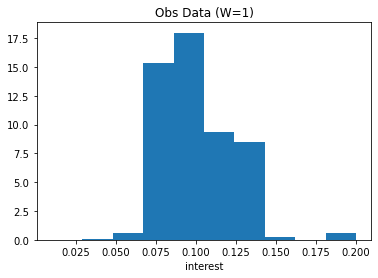

In [64]:
plt.hist(df_policy["i"], density=True)
plt.title("Obs Data (W=1)")
plt.xlabel("interest");

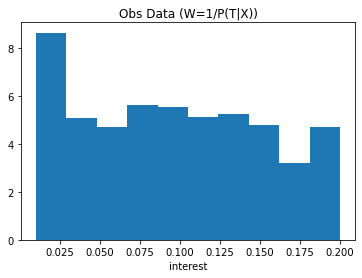

In [65]:
plt.hist(df_policy["i"], density=True, weights=1/df_policy["ps"])
plt.title("Obs Data (W=1/P(T|X))")
plt.xlabel("interest");

In [66]:
def with_policy(df, model):
    
    all_prices = sorted(df["i"].unique())
    
    return (
        df
        .reset_index()
        .assign(key=1)
        .drop(columns=["i_policy"])
        .merge(pd.DataFrame(dict(key=1, i_policy = all_prices)))
        .assign(risk_pred = lambda d: model.predict(d[["i_policy", "x"]]))
        .assign(profit_pred = lambda d: profit_given_risk(d["i_policy"], d["risk_pred"]))
        .assign(prediction_rank = lambda d: d.groupby("index")["profit_pred"].transform("rank", method="first", ascending=False))
        .assign(qs = lambda d: (d["prediction_rank"] == 1)*1)
        .query("i==i_policy")
        .drop(columns=["prediction_rank", "key", "index"])
        
    )


df_policy_eval_causal = with_policy(df_policy, model_causal)
df_policy_eval = with_policy(df_policy, model)

df_policy_eval_causal.head()

,x,a,b,i,is_exp,p_exp,i_exp,test_ps,ps,r,profit,i_policy,risk_pred,profit_pred,qs
7,0.27,-3.67,25,0.08,0,0.33,0.16,0.122133,0.666667,0.192717,993.445563,0.08,0.141358,1120.268740,1
21,0.20,-4.88,25,0.03,1,0.33,0.03,0.001000,0.000333,0.006733,1144.736682,0.03,0.027696,1099.471142,0
40,0.50,-2.00,25,0.03,1,0.33,0.03,0.001000,0.000333,0.313177,483.038646,0.03,0.474980,133.662400,0
65,0.31,-3.21,25,0.09,0,0.33,0.16,0.177867,0.666667,0.286917,810.249889,0.09,0.242327,923.447507,1
84,0.39,-2.59,25,0.09,0,0.33,0.18,0.177867,0.666667,0.211399,1001.960286,0.09,0.288555,806.092476,1


In [67]:
def w_avg(df):
    return np.average(df["profit"], weights=df["qs"]/df["ps"])

bs_sample_causal_reeval = [w_avg(df_policy_eval_causal.sample(frac=1, replace=True)) for _ in range(500)]

In [68]:
np.quantile(bs_sample_causal_reeval, [0.025, 0.975])

array([915.64202059, 960.9525348 ])

In [69]:
def w_avg(df):
    return np.average(df["profit"], weights=df["qs"]/df["ps"])

bs_sample_reeval = [w_avg(df_policy_eval.sample(frac=1, replace=True)) for _ in range(500)]

In [70]:
np.mean(bs_sample_reeval)

1054.3442412430873

In [71]:
np.quantile(bs_sample_reeval, [0.025, 0.975])

array([ 870.77023318, 1254.59135005])

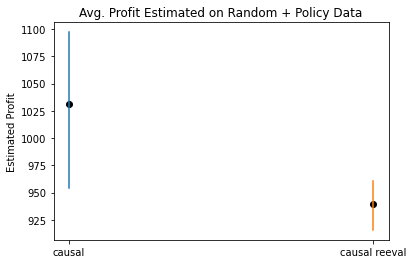

In [72]:
plt.title("Avg. Profit Estimated on Random + Policy Data")
plt.plot(["causal", "causal"], np.quantile(bs_sample_causal, [0.025, 0.975]), label="causal")
plt.plot(["causal reeval", "causal reeval"], np.quantile(bs_sample_causal_reeval, [0.025, 0.975]), label="causal reeval")

plt.scatter(["causal", "causal reeval"],
            [np.quantile(bs_sample_causal, 0.5), np.quantile(bs_sample_causal_reeval, 0.5)], color="black")
plt.ylabel("Estimated Profit");